## Ejercicio 1

Construir un pipeline de clasificación con un modelo Keras MLP. Pueden comenzar con una versión simplicada que sólo tenga una capa de Input donde pasen los valores de las columnas de one-hot-encodings.

Entrenar uno o varios modelos (con dos o tres es suficiente, veremos más de esto en el práctico 2). Evaluar los modelos en el conjunto de dev y test.

# Procesamiento de datos usando Tensorflow

Cuando trabajamos con Tensorflow, existen una gran variedad de formas en las que podemos alimentar los datos a nuestra red neuronal. Esto también tiene que ver con el tipo de datos y los pasos de pre-procesamiento que sean necesarios.

En la notebook 1 se utilizó un conjunto de datos de imágenes, esencialmente con variables numéricas. En esta notebook trabajemos con datos categóricos y profundizaremos en cómo trasformar los ejemplos dentro del pipeline de clasificación.

Ante un problema de clasificación, lo primero que debemos hacer es **inspeccionar los datos y construir un prototipo de modelo**. La forma más fácil de hacerlo es con notebooks. Sin embargo, a la hora de llevar a cabo experimentos con redes neuronales, un entorno interactivo puede no ser la mejor opción. En primer lugar, explorar los hiperparámetros de una arquitectura neuronal puede llevar varias horas e incluso días, perdiendo todas las ventajas del entorno interactivo. En segundo lugar, no podemos encolar ejecuciones de notebooks para reservar recursos como las GPUs.

Por ello, primero realizaremos una exploración inicial de los datos en esta notebook. Una vez que decidamos qué tipo de modelo implementar, pasaremos el modelo a un script de python que cargue los datos, construya el modelo, lo entrene, y finalmente guarde las métricas relevantes.

En esta notebook, veremos varios conceptos avanzados de entrenamiento de redes:

  * Uso de `tf.data.Dataset` para optimizar la ingesta de datos. 
  * Uso de capas `tf.layers.Embedding`.
  * Combinación de distintos tipos de features en un mismo modelo con múltiples inputs.
  * MLFlow para registro de experimentos

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers, models

TensorFlow 2.x selected.


In [0]:
import argparse
import os
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')
seaborn.set_context('paper')

from sklearn.model_selection import train_test_split
#from tensorflow.keras import layers, models

In [0]:
def process_features(df):
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # Create and append numeric columns
    # Don't forget to normalize!
    # ....
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': numpy.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
        features[embedded_col] = df[embedded_col].values

    # Convert labels to one-hot encodings
    targets = tf.keras.utils.to_categorical(df[target_col], nlabels)
    
    return features, targets

In [4]:
print('All operations completed')

All operations completed


## Cargando los datos

Una vez más, estaremos trabajando con el conjunto de datos `petfinder`. Deben descargarlo siguiendo las instrucciones en la [notebook 0](./0_set_up.ipynb), descomprimirlo y luego ajustar la dirección en esta notebook según corresponda. 

Algunas de las preguntas que respondemos durante esta etapa son:

 * ¿Qué tipo de tarea tengo que resolver? ¿Clasificación o regresión?
 * ¿Qué distribución tienen mis etiquetas?
 * ¿Qué tipo de datos tengo disponible para la clasificación? ¿Cuáles son útiles?
 * Dadas las características disponibles y el problema que quiero resolver, ¿qué tipo de clasificador o arquitectura conviene utilizar? ¿De qué manera se están representando las causas latentes del problema en el modelo elegido?
 * Dadas las características disponibles y el modelo elegido, ¿de qué forma representaremos cada una de dichas características?
 
En esta clase utilizaremos redes neuronales como modelos porque es el objetivo de la materia, pero sigue siendo importante qué aspectos podremos capturar con este tipo de modelo, especialmente para tener intuiciones sobre qué hiperparámetros explorar.

In [0]:
DATA_DIRECTORY = 'https://raw.githubusercontent.com/Rondamon/AprendizajeProfundo/master/Dataset_PetFinder/'

In [0]:
# Take a sample of data

dataset, dev_dataset = train_test_split(
    pandas.read_csv(os.path.join(DATA_DIRECTORY, 'train.csv')), test_size=0.2)

In [7]:
dataset[:3]

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID
4298,2,6,266,0,1,2,7,0,2,1,1,1,2,1,1,0,41326,"Name: Mickey 6 months old, Male kitten.. Fully...",3,6085
78,1,2,307,307,2,1,4,7,3,1,2,2,2,1,6,0,41327,There's a groups of puppies near my working pl...,3,110
640,2,24,265,264,2,1,4,7,2,3,3,3,3,1,6,0,41326,2 mom cats 4 kittens,4,904


### Tipos de datos

In [8]:
dataset.dtypes

Type              int64
Age               int64
Breed1            int64
Breed2            int64
Gender            int64
Color1            int64
Color2            int64
Color3            int64
MaturitySize      int64
FurLength         int64
Vaccinated        int64
Dewormed          int64
Sterilized        int64
Health            int64
Quantity          int64
Fee               int64
State             int64
Description      object
AdoptionSpeed     int64
PID               int64
dtype: object

In [0]:
target_col = 'AdoptionSpeed'
nlabels = dataset[target_col].unique().shape[0]

In [0]:
TARGET_COL = 'AdoptionSpeed'

### Distribución de las etiquetas

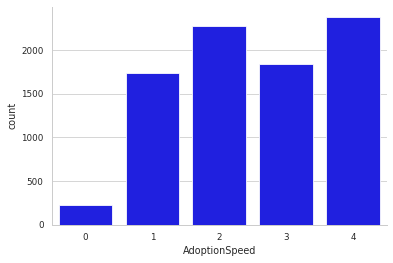

In [11]:
seaborn.countplot(dataset.AdoptionSpeed, color='blue')
seaborn.despine()

https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

https://www.tensorflow.org/tutorials/structured_data/feature_columns

Why not to use feature_columns https://github.com/tensorflow/tensorflow/issues/27895

feature_columns doc 2.0 https://www.tensorflow.org/api_docs/python/tf/feature_column

## Creando las representaciones

Tenemos una serie de variables categóricas y ordinales que pueden ser útiles para predecir la velocidad de adopción. Para cada una de ellas, tenemos que pensar cuál es la mejor forma de pasarla como input a la red. Analizaremos algunas de ellas:

  * `Age` es una variable numérica discreta, podemos representarla con una única neurona con el valor original. Es muy importante normalizar este tipo de variables.
  * `Gender` es una variable categórica. Como la variable tiene pocos valores, utilizaremos un *one-hot encoding* como representación.
  * `Breed1` es una variable categórica que puede tomar muchos valores. Podemos utilizar *one-hot encoding*, lo cual resultará en vectores esparsos de dimensión cercana a 300. Alternativamente, podemos utilizar una capa de embedding para representar sus valores con un vector denso de baja dimesionalidad. Pregunta: ¿qué información podrá capturar este embedding?

Una vez que definimos cómo vamos a representar cada una de las columnas, las pre-procesamos para formar un numpy array. En este caso, procesaremos el dataset completo porque estamos seguros de que entrará en memoria. En otros casos, puede ser necesario un pre-procesamiento por batches, o incluso utilizar las funciones de Tensorflow incluidas en el módulo `feature_column`.

NOTA: para este ejercicio, intentamos utilizar `feature_column` pero causaba que la loss diverga. La documentación no ha sido totalmente actualizada a Tensorflow 2.0, y puede ser que nos encontremos ante un error de cambio de versiones. Pueden encontrar más ejemplos en [este link](https://www.tensorflow.org/tutorials/structured_data/feature_columns).

In [0]:
# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender', 'Color1']
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1']
}
numeric_columns = ['Age', 'Fee']

In [0]:
X_train, y_train = process_features(dataset)

In [14]:
X_train

{'Breed1': array([266, 307, 265, ..., 307, 285, 179]),
 'direct_features': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 1., 0., 0.]], dtype=float32)}

In [15]:
direct_features_input_shape = (X_train['direct_features'].shape[1],)
direct_features_input_shape

(10,)

## Creando datasets iterables

Como hemos visto, las redes neuronales se entrenan iterativamente con el algoritmo de *stochastic gradient descent*. Una forma de hacerlo es pasarle el dataset entero al método `fit` de un modelo de Keras, como vimos en la notebook anterior. Sin embargo, esto tiene algunas desventajas:

* El dataset procesado debe entrar en memoria
* El dataset procesado debe entrar en disco, lo cual no siempre es factible para encodings y datasets realmente grandes (ej: la wikipedia)
* Una vez que la GPU ha terminado de procesar los datos, devuelve el control a la CPU (que estaba esperando sin hacer nada), y espera a que los nuevos datos son particionados.
* No es posible usar cálculo distribuido en distintos file systems.

Las dos primeras desventajas se solucionan preprocesando los datos en batches, y creando matrices anchas pero con pocas filas. Sin embargo, escribir este código manualmente puede ser complejo y en general lo hacemos de manera ineficiente. Solucionar las dos últimas es bastante más complicado y a la vez crítico. 

> **No importa qué tan buen hardware usemos para el entrenamiento del modelo, si seguimos limitados por un procesamiento de datos lineal y single core.**

Por eso es recomendable utilizar las abstracciones nativas provistas por Tensorflow que paralelizan internamente muchas funciones.

Para ello, crearemos un objeto `tf.data.Dataset` iterable a partir de nuestro dataframe de pandas y no tendremos que preocuparnos por la optimización de la GPU. Los datasets saben cómo crear batches, shuffles, aplicar funciones map y filter, etc. Además, podemos crear datasets a partir de diversas estructuras de datos, como numpy arrays o archivos. Pueden encontrar más información sobre los distintos tipos de Datasets en [este tutorial](https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428)

In [0]:
batch_size = 32 #Estaba en 32
# TODO shuffle the train dataset!
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices(
    process_features(dev_dataset)).batch(batch_size)

Podemos ver qué es lo que tiene adentro en dataset obteniendo la primera operación.

In [17]:
x_batch, y_batch = next(iter(train_ds))
x_batch, y_batch

({'Breed1': <tf.Tensor: id=20, shape=(32,), dtype=int64, numpy=
  array([266, 307, 265, 266, 266, 265, 307,  64, 307, 266, 265, 265, 266,
         307, 266, 304, 307, 307, 266, 266,  39, 264, 265, 265, 307, 307,
         266, 307, 264, 307, 266, 109])>,
  'direct_features': <tf.Tensor: id=21, shape=(32, 10), dtype=float32, numpy=
  array([[1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
     

## Construyendo el modelo

Construimos el modelo, por ahora con sólo una capa oculta. Sin embargo, la complejidad más grande es combinar los features que tienen embeddings con los que no. Por cada tipo de feature, tenemos que agregar una capa de `Input`. Tener en cuenta que cada embedded feature se considera distinto.

Como tenemos más de un input, tenemos que usar la API funcional de Keras en lugar de usar un modelo `Sequential`. La API funcional puede construir modelos más flexibles, ya que conectaremos explícitamente cada capa con su capa siguiente.

Pueden encontrar otro ejemplo similar a este código en [esta notebook](https://www.kaggle.com/alexanderkireev/deep-learning-support-9663).

In [18]:
tf.keras.backend.clear_session()

hidden_layer_size = 32 #Venia con 64

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)
    
# Concatenate everything together
features = layers.concatenate(embedding_layers + [direct_features_input])

dense1 = layers.Dense(hidden_layer_size, activation='relu')(features)
output_layer = layers.Dense(nlabels, activation='softmax')(dense1)

model = models.Model(inputs=inputs, outputs=output_layer)

Adding embedding of size 77 for layer Breed1


In [19]:
tf.keras.backend.clear_session()

hidden_layer_size1 = 32

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)
    
# Concatenate everything together
features = layers.concatenate(embedding_layers + [direct_features_input])

dense1 = layers.Dense(hidden_layer_size1, activation='relu')(features)
dense2 = layers.Dense(hidden_layer_size1, activation='relu')(dense1)
output_layer = layers.Dense(nlabels, activation='softmax')(dense2)

model1 = models.Model(inputs=inputs, outputs=output_layer)

Adding embedding of size 77 for layer Breed1


In [20]:
tf.keras.backend.clear_session()

hidden_layer_size2 = 128 #Venia con 64

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)
    
# Concatenate everything together
features = layers.concatenate(embedding_layers + [direct_features_input])

dense1 = layers.Dense(hidden_layer_size2, activation='relu')(features)
output_layer = layers.Dense(nlabels, activation='softmax')(dense1)

model2 = models.Model(inputs=inputs, outputs=output_layer)

Adding embedding of size 77 for layer Breed1


### Métricas de evaluación

Al igual que en la materia de aprendizaje supervisado, utilizaremos el accuracy como métrica, y agregaremos el score f1. Es opcional implementar esta predicción como un problema de regresión.

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy']) #Optimizer original era "adam"
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 77)        23716       Breed1[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Squeeze (TensorFlow [(None, 77)]         0           embedding[0][0]                  
__________________________________________________________________________________________________
direct_features (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

In [22]:
model1.compile(loss='categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy']) #Optimizer original era "adam"
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 77)        23716       Breed1[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Squeeze (TensorFlow [(None, 77)]         0           embedding[0][0]                  
__________________________________________________________________________________________________
direct_features (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

In [23]:
model2.compile(loss='categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy']) #Optimizer original era "adam"
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 77)        23716       Breed1[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Squeeze (TensorFlow [(None, 77)]         0           embedding[0][0]                  
__________________________________________________________________________________________________
direct_features (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

## Entrenando el modelo

Una vez que tenemos definido nuestro modelo, tenemos que entrenarlo. Sin embargo, para que los resultados sean útiles, tenemos que llevar un registro de qué hiperparámetros utilizamos y qué performance obtuvimos. Para eso, usaremos [MLFlow](https://mlflow.org/docs/latest/quickstart.html), una librería muy simple pero que permite sistematizar el registro de resultados.

MLFlow soporta muchísimos casos de uso, pero por ahora sólo usaremos el más básico de todos para organizar el entrenamiento. Llamaremos *experiments* a los cambios grandes en la arquitectura, por ejemplo, si agregamos muchas capas nuevas o mecanismos de regularización. Llamaremos *runs* a las distintas ejecuciones de la misma arquitectura donde variamos sólo algunos hiperparámetros, como funciones de activación, cantidad de neuronas, tamaños de los embeddings, etc.

Para acceder a la interfaz gráfica donde podemos ver las *run*, en una nueva terminal tenemos que ejecutar 

    $ mlflow ui -p PORT
    
Y abrir `https://localhost:PORT` en nuestro navegador (donde `PORT` es un número de puerto). Si estamos en un servidor, es probab, tendremos que abrir un nuevo puerto ssh a `PORT`.

In [24]:
try:
    import mlflow
except Exception:
    !pip install mlflow
    import mlflow
    pass

In [0]:
#$ mlflow ui -p 8010

In [26]:
#Caso base pero con un poco más de epochs

mlflow.set_experiment('very_base_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    # mlflow.log_param('numerical_columns', numerical_columns)  # Not using these yet
    
    # Train
    epochs = 50 #Oriniginal en 10
    history = model.fit(train_ds, epochs=epochs)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)
    
#accuracy baseline: 0.3188474178314209
#caso 1: 0.31979215145111084

Epoch 1/50
265/265 [==============================] - 4s 15ms/step - loss: 1.4815 - accuracy: 0.2956
Epoch 2/50
265/265 [==============================] - 2s 7ms/step - loss: 1.4401 - accuracy: 0.3173
Epoch 3/50
265/265 [==============================] - 2s 7ms/step - loss: 1.4323 - accuracy: 0.3282
Epoch 4/50
265/265 [==============================] - 2s 6ms/step - loss: 1.4260 - accuracy: 0.3366
Epoch 5/50
265/265 [==============================] - 2s 7ms/step - loss: 1.4207 - accuracy: 0.3395
Epoch 6/50
265/265 [==============================] - 2s 7ms/step - loss: 1.4160 - accuracy: 0.3395
Epoch 7/50
265/265 [==============================] - 2s 7ms/step - loss: 1.4120 - accuracy: 0.3429
Epoch 8/50
265/265 [==============================] - 2s 7ms/step - loss: 1.4083 - accuracy: 0.3415
Epoch 9/50
265/265 [==============================] - 2s 7ms/step - loss: 1.4052 - accuracy: 0.3441
Epoch 10/50
265/265 [==============================] - 2s 8ms/step - loss: 1.4023 - accuracy: 0.345

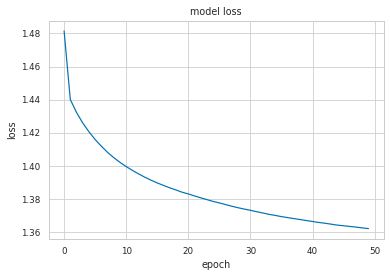

In [27]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [28]:
#Dos layers con la misma cantidad de neuronas que el caso base

mlflow.set_experiment('very_base_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size1)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    # mlflow.log_param('numerical_columns', numerical_columns)  # Not using these yet
    
    # Train
    epochs = 50 #Oriniginal en 10
    history1 = model1.fit(train_ds, epochs=epochs)
    
    # Evaluate
    loss1, accuracy1 = model1.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss1, accuracy1))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss1)
    mlflow.log_metric('accuracy', accuracy1)
    
#accuracy base: 0.3188474178314209
#accuracy: 0.3008975088596344

Epoch 1/50
265/265 [==============================] - 4s 14ms/step - loss: 1.4693 - accuracy: 0.2953
Epoch 2/50
265/265 [==============================] - 2s 8ms/step - loss: 1.4398 - accuracy: 0.3218
Epoch 3/50
265/265 [==============================] - 2s 8ms/step - loss: 1.4320 - accuracy: 0.3310
Epoch 4/50
265/265 [==============================] - 2s 8ms/step - loss: 1.4254 - accuracy: 0.3362
Epoch 5/50
265/265 [==============================] - 2s 8ms/step - loss: 1.4196 - accuracy: 0.3379
Epoch 6/50
265/265 [==============================] - 2s 8ms/step - loss: 1.4147 - accuracy: 0.3412
Epoch 7/50
265/265 [==============================] - 2s 8ms/step - loss: 1.4100 - accuracy: 0.3421
Epoch 8/50
265/265 [==============================] - 2s 8ms/step - loss: 1.4060 - accuracy: 0.3431
Epoch 9/50
265/265 [==============================] - 2s 8ms/step - loss: 1.4023 - accuracy: 0.3455
Epoch 10/50
265/265 [==============================] - 2s 8ms/step - loss: 1.3987 - accuracy: 0.346

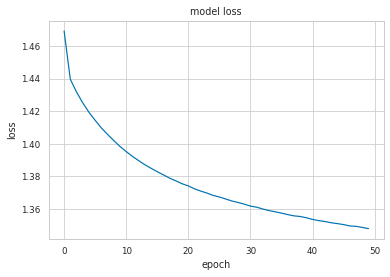

In [29]:
plt.plot(history1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [30]:
#Una layer de muchas neuronas
mlflow.set_experiment('very_base_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size2)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    # mlflow.log_param('numerical_columns', numerical_columns)  # Not using these yet
    
    # Train
    epochs = 50 #Oriniginal en 10
    history2 = model2.fit(train_ds, epochs=epochs)
    
    # Evaluate
    loss2, accuracy2 = model2.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss2, accuracy2))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss2)
    mlflow.log_metric('accuracy', accuracy2)
    
#accuracy base: 0.3188474178314209
#accuracy: 0.2961738407611847

Epoch 1/50
265/265 [==============================] - 4s 16ms/step - loss: 1.4632 - accuracy: 0.3008
Epoch 2/50
265/265 [==============================] - 2s 8ms/step - loss: 1.4378 - accuracy: 0.3197
Epoch 3/50
265/265 [==============================] - 2s 8ms/step - loss: 1.4299 - accuracy: 0.3288
Epoch 4/50
265/265 [==============================] - 2s 7ms/step - loss: 1.4236 - accuracy: 0.3341
Epoch 5/50
265/265 [==============================] - 2s 7ms/step - loss: 1.4182 - accuracy: 0.3360
Epoch 6/50
265/265 [==============================] - 2s 7ms/step - loss: 1.4133 - accuracy: 0.3403
Epoch 7/50
265/265 [==============================] - 2s 8ms/step - loss: 1.4088 - accuracy: 0.3429
Epoch 8/50
265/265 [==============================] - 2s 7ms/step - loss: 1.4046 - accuracy: 0.3444
Epoch 9/50
265/265 [==============================] - 2s 7ms/step - loss: 1.4008 - accuracy: 0.3475
Epoch 10/50
265/265 [==============================] - 2s 7ms/step - loss: 1.3973 - accuracy: 0.348

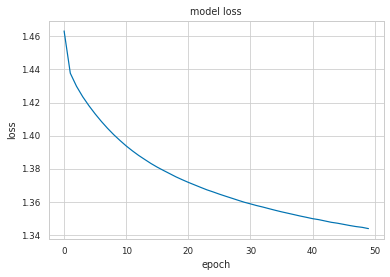

In [31]:
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Evaluando del modelo

Además de tener en cuenta las métricas de performance del modelo, es importante mirar los resultados obtenidos y controlar que el modelo efectivamente está aprendiendo algo relevante.

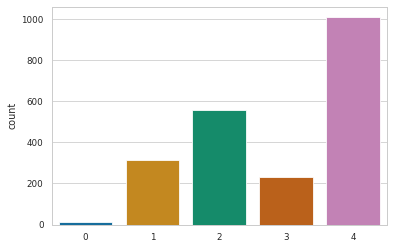

In [32]:
#Predicciones para el caso 2 (model1), con dos layers y 32 neuronas cada layer.
predictions = numpy.argmax(model1.predict(test_ds), axis=1)
seaborn.countplot(predictions)

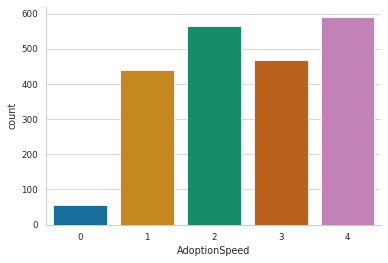

In [33]:
seaborn.countplot(dev_dataset.AdoptionSpeed)
seaborn.despine()